In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('src')  # so Python can find src/affine

from src.get_derived_features import get_hurst, get_basic_sentarc_features, detrend

In [2]:
# collect data from multiple JSON files into a single DataFrame
# get all jsons in results/partial_results_* and merge them into a single DataFrame
path = "results/partial_results/"

files = glob.glob(os.path.join(path, "*.json"))
print(f"Found {len(files)} files in {path}")    

data = []
for file in files:
    print(f"Loading {file}")
    with open(file, 'r') as f:
        data.extend(json.load(f))

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)
print('---------')
print('number of rows:', len(df))
df.head()

Found 53 files in results/partial_results/
Loading results/partial_results/partial_results_1400_20250618_145036.json
Loading results/partial_results/partial_results_5000_20250618_145036.json
Loading results/partial_results/partial_results_2500_20250618_145036.json
Loading results/partial_results/partial_results_1300_20250618_145036.json
Loading results/partial_results/partial_results_1900_20250618_145036.json
Loading results/partial_results/partial_results_2800_20250618_145036.json
Loading results/partial_results/partial_results_final_20250618_145036.json
Loading results/partial_results/partial_results_2200_20250618_145036.json
Loading results/partial_results/partial_results_1000_20250618_145036.json
Loading results/partial_results/partial_results_2100_20250618_145036.json
Loading results/partial_results/partial_results_1700_20250618_145036.json
Loading results/partial_results/partial_results_2600_20250618_145036.json
Loading results/partial_results/partial_results_2700_20250618_145036

text_id                                              vader  \
0  33717112  [0.3612, 0.4588, 0.0, 0.3182, 0.0, 0.2263, 0.3...   
1  33701860  [0.0772, 0.6705, 0.0, 0.4019, 0.5423, 0.7506, ...   
2  33695572  [0.0, 0.0, 0.0, -0.1289, 0.0, 0.6908, 0.0, 0.0...   
3  33680803  [0.0, 0.0, -0.4201, 0.0, 0.1027, 0.0, 0.0, 0.0...   
4  33661423  [0.0, 0.0, 0.0, 0.0, 0.2846, 0.0, 0.0, -0.296,...   

                                             syuzhet  \
0  [1.1, 0.75, 0.35, 0.85, 0.050000000000000044, ...   
1  [0.65, 0.75, 0.0, 1.4, 0.8, 1.5, 0.5, 0.8, 0.0...   
2  [0.0, 0.0, 1.1, -0.5, 1.7000000000000002, 0.5,...   
3  [0.0, 0.6, -0.5, -0.75, 0.4, 0.65, 0.0, 0.0, 0...   
4  [0.0, 0.0, 0.0, 0.8, 0.25, 0.0, 0.0, -0.5, 0.0...   

                                                text  \
0  The sun streamed through the tree's thick bran...   
1  "Father, the only things I want are to be a ma...   
2  "Hurry up!" Melinoe shouts, tapping her foot a...   
3  Through a forest in Greece, many thousands of ...   
4  'You still look the same.' Dionysus spun aroun...   

                                           sentences  \
0  [The sun streamed through the tree's thick bra...   
1  ["Father, the only things I want are to be a m...   
2  ["Hurry up!", Melinoe shouts, tapping her foot...   
3  [Through a forest in Greece, many thousands of...   
4  ['You still look the same.', Dionysus spun aro...   

     twitter-xlm-roberta-base-sentiment-multilingual  
0  [0.0, 0.9207668900489807, 0.0, 0.9714448451995...  
1  [0.6886814832687378, 0.9796002507209778, 0.0, ...  
2  [0.5489041209220886, 0.0, 0.8226926922798157, ...  
3  [0.0, -0.9434750080108643, -0.9725767970085144...  
4  [0.6179378628730774, 0.5938321948051453, 0.0, ...

In [3]:
# drop duplicates
df = df.drop_duplicates(subset=['text_id']).reset_index(drop=True)
print('---------')
print('number of rows after dropping duplicates:', len(df))

---------
number of rows after dropping duplicates: 5096


Lets just do some checking, how are the lengths, anything look wrong?
Also plot some sentiment scores to see how they compare.

In [4]:
print(len(df['sentences'][1]))
print(len(df['syuzhet'][1]))
print(len(df['twitter-xlm-roberta-base-sentiment-multilingual'][1]))
print(len(df['text'][1].split('.'))) # seems like tokenization is done by sentence (approx)

39
39
39
40


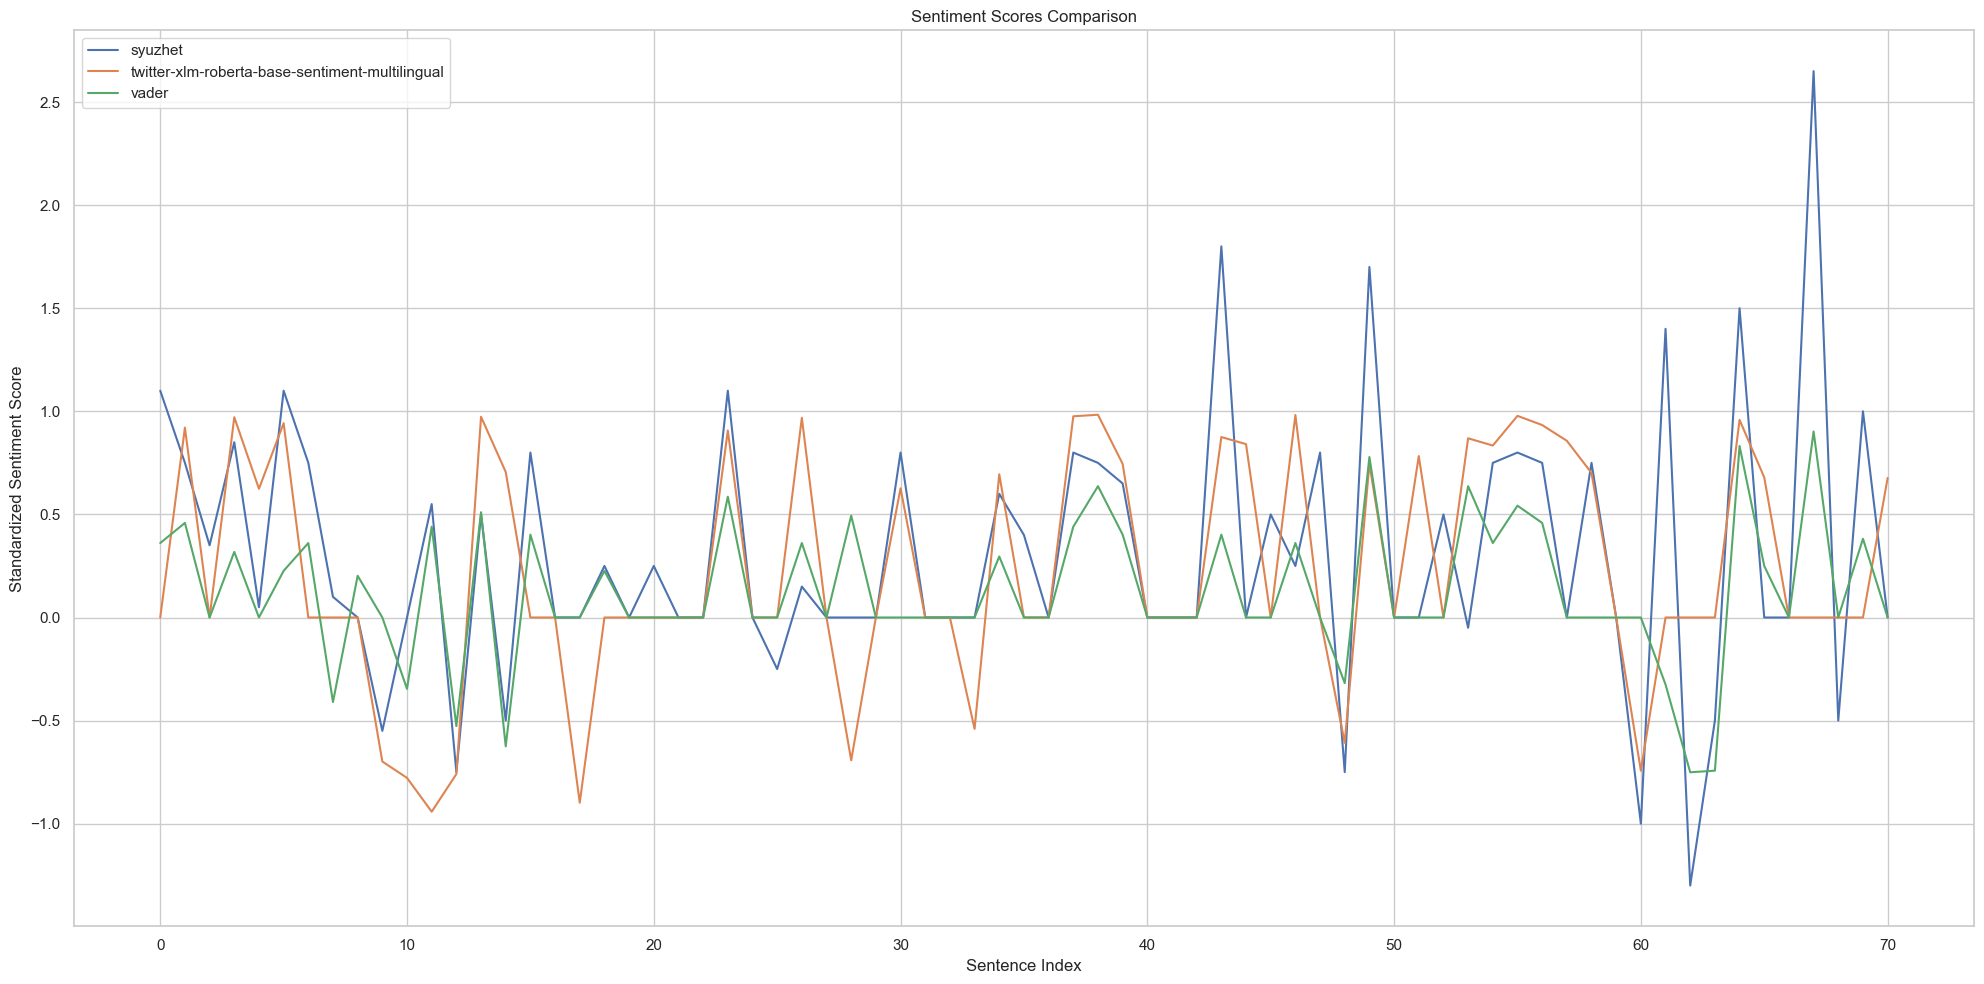

In [5]:
# let's plot the sentiment scores (vader, syuzhet, and xlm-roberta) for the first row
test_data = df.copy()
cols_to_scale = ['syuzhet', 'twitter-xlm-roberta-base-sentiment-multilingual', 'vader']
x_scores = 100  # number of sentences to plot

# Truncate first row's lists safely
first_row = {}
for col in cols_to_scale:
    first_row[col] = test_data.loc[0, col][:x_scores]

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
for col in cols_to_scale:
    plt.plot(first_row[col], label=col)
plt.title('Sentiment Scores Comparison')
plt.xlabel('Sentence Index')
plt.ylabel('Standardized Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

# right, they are on different scales, so we should standardize

Okay lets get on with it

In [6]:
# merge data w original df to get additional tags
metadata = pd.read_csv("/Users/au324704/Downloads/transfer_3170830_files_331009ec/fanfics_Greek_myth_metadata.csv")
metadata = metadata[['work_id','category', 'fandom',
       'additional tags', 'language']]
# rename work_id to text_id to match df
metadata.rename(columns={'work_id': 'text_id'}, inplace=True)
merged = df.merge(metadata, how='left', on='text_id')

# function to normalize the sentiment scores (they are on different scales)
def scale_sentiment_minmax(syuzhet_column):
    """ Scales the sentiment scores in the given column to a range of -1 to 1. """
    filtered = syuzhet_column.dropna().loc[syuzhet_column.apply(lambda x: isinstance(x, list) and len(x) > 0)]
    all_vals = np.concatenate(filtered.tolist()).reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(all_vals)
    
    return syuzhet_column.apply(
        lambda arc: scaler.transform(np.array(arc).reshape(-1, 1)).flatten().tolist()
        if isinstance(arc, list) and len(arc) > 0 else np.nan
    )

In [47]:

### --- SETTING UP SENTIMENT ANALYSIS METHOD --- ###

# --- NB: you can choose which sentiment analysis method to use here ---
# (for all subsequent analyses, this will be used)

METHOD_TO_USE = 'syuzhet'  # or 'vader' or 'twitter-xlm-roberta-base-sentiment-multilingual'
SCALE = False # whether to scale the sentiment scores or not before taking mean and std

# dropna on sentiment method to use
merged = merged.dropna(subset=[METHOD_TO_USE])

if SCALE == True:
    merged[METHOD_TO_USE] = scale_sentiment_minmax(merged[METHOD_TO_USE])


# ---- extract features ---- #

# get MEAN and SD of sent -- so here you can chose whether scaled, unscaled and which SA method you want to use
merged[['mean_sent', 'sd_sent']] = merged[METHOD_TO_USE].apply(lambda x: pd.Series(get_basic_sentarc_features(x)))

# we gotta introduce some threshold here for the length -- sad -- but detrending is not possible for very short arcs
# so let's say 50 sentences
THRESHOLD = 50
# so adding a function to detrend only if the arc is long enough (detrend itself is defined in get_derived_features.py)
def detrend_if_long(arc):
    if isinstance(arc, list) and len(arc) > THRESHOLD:
        return detrend(arc) # detrend function from get_derived_features.py
    else:
        return np.nan

# DETREND the sentiment arcs
merged['detrended_arc'] = merged[METHOD_TO_USE].apply(detrend_if_long)
merged = merged.dropna(subset=['detrended_arc'])

# option to get HURST
merged['hurst'] = merged[METHOD_TO_USE].apply(lambda x: get_hurst(x) if isinstance(x, list) else np.nan)

print("len of notna when detrending arcs (-short texts):", len(merged))
print("len of original df:", len(df))
merged.head(2)


len of notna when detrending arcs (-short texts): 3597
len of original df: 5096


text_id                                              vader  \
0  33717112  [0.3612, 0.4588, 0.0, 0.3182, 0.0, 0.2263, 0.3...   
2  33695572  [0.0, 0.0, 0.0, -0.1289, 0.0, 0.6908, 0.0, 0.0...   

                                             syuzhet  \
0  [1.1, 0.75, 0.35, 0.85, 0.050000000000000044, ...   
2  [0.0, 0.0, 1.1, -0.5, 1.7000000000000002, 0.5,...   

                                                text  \
0  The sun streamed through the tree's thick bran...   
2  "Hurry up!" Melinoe shouts, tapping her foot a...   

                                           sentences  \
0  [The sun streamed through the tree's thick bra...   
2  ["Hurry up!", Melinoe shouts, tapping her foot...   

     twitter-xlm-roberta-base-sentiment-multilingual  category  \
0  [0.0, 0.9207668900489807, 0.0, 0.9714448451995...       M/M   
2  [0.5489041209220886, 0.0, 0.8226926922798157, ...  F/M, Gen   

                                              fandom  \
0  The Song of Achilles - Madeline Miller, Ancien...   
2  Hadestown - Mitchell, Ancient Greek Religion &...   

                                     additional tags language  mean_sent  \
0  Gay, theyre gay af, Everyone Is Gay, its ancie...  English   0.226683   
2  Growing Up, Mother-Daughter Relationship, Moth...  English   0.133834   

    sd_sent                                      detrended_arc  hurst  \
0  0.543663  [1.0, 0.7648162645404015, 0.529632529080803, 0...   0.67   
2  0.590644  [-0.09293002086884572, -0.14407579724035113, -...   0.50   

   sinuosity subset  
0  70.208021  other  
2   2.178981  other

In [ ]:
# # try out sinuoisity measure (could give us an idea of the "rollercoaster"-ness of the sentiment arc)
# this is just some playtime, not sure that this would work and how well my function works
# from src.get_derived_features import get_sinuosity

# test0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# print("Sinuosity of test arc:", get_sinuosity(test0))

# test2 = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5]
# print("Sinuosity of test2 arc:", get_sinuosity(test2))

# test3 = [0, 0.5, 0, 1, 0, 0.5, 0, 1, 0, 0.5, 0, 1, 0, 0.5, 0, 1]
# print("Sinuosity of test3 arc:", get_sinuosity(test3))

# # get sinuosity
# merged['sinuosity'] = merged['detrended_arc'].apply(lambda x: get_sinuosity(x))
# # probably we want to do this on the detrended arcs, or change to METHOD_TO_USE (i.e., raw sentiment, selected method)

# # print number of nans in sinuosity
# print("Number of NaNs in sinuosity:", merged['sinuosity'].isna().sum())


In [48]:
# now we want to tag "fluff" and "angst" and "hurt/comfort" if those are in the additional tags

# function adopted to match the tagging code from Julia
def tag_genre(tags):
    if not isinstance(tags, str):
        return 'other'

    tag_list = [tag.strip().lower() for tag in tags.split(',')]
    tag_str = ' '.join(tag_list)

    # Exclusion stuff --> other
    exclusions = ['angst and fluff', 'flangst']

    # Check presence of specific tags
    has_fluff = 'fluff' in tag_str
    has_angst = 'angst' in tag_str
    has_hurt_comfort = 'hurt/comfort' in tag_str or 'hurt comfort' in tag_str

    # Fluff only if it has fluff and none of the others
    if has_fluff and not has_angst and not has_hurt_comfort and not any(ex in tag_str for ex in exclusions):
        return 'fluff'

    # Angst only if it has angst and none of the others
    if has_angst and not has_fluff and not has_hurt_comfort and not any(ex in tag_str for ex in exclusions):
        return 'angst'

    # Hurt/Comfort only if it has hc and none of the others
    if has_hurt_comfort and not has_fluff and not has_angst and not any(ex in tag_str for ex in exclusions):
        return 'hurt/comfort'

    # Anything else is 'other'
    return 'other'

# apply
merged['subset'] = merged['additional tags'].apply(tag_genre)
print(merged['subset'].value_counts())

# nice, so make groups by subset now
fluff = merged[merged['subset'] == 'fluff']
angst = merged[merged['subset'] == 'angst']
hurt_comfort = merged[merged['subset'] == 'hurt/comfort']
other = merged[merged['subset'] == 'other']

# print lens
print("--- Categories and their counts: ---")
print(f"Angst: {len(angst)}")
print(f"Fluff: {len(fluff)}")
print(f"Hurt/Comfort: {len(hurt_comfort)}")
print(f"Other: {len(other)}")

merged.head(2)

subset
other           2950
angst            292
fluff            269
hurt/comfort      86
Name: count, dtype: int64
--- Categories and their counts: ---
Angst: 292
Fluff: 269
Hurt/Comfort: 86
Other: 2950


text_id                                              vader  \
0  33717112  [0.3612, 0.4588, 0.0, 0.3182, 0.0, 0.2263, 0.3...   
2  33695572  [0.0, 0.0, 0.0, -0.1289, 0.0, 0.6908, 0.0, 0.0...   

                                             syuzhet  \
0  [1.1, 0.75, 0.35, 0.85, 0.050000000000000044, ...   
2  [0.0, 0.0, 1.1, -0.5, 1.7000000000000002, 0.5,...   

                                                text  \
0  The sun streamed through the tree's thick bran...   
2  "Hurry up!" Melinoe shouts, tapping her foot a...   

                                           sentences  \
0  [The sun streamed through the tree's thick bra...   
2  ["Hurry up!", Melinoe shouts, tapping her foot...   

     twitter-xlm-roberta-base-sentiment-multilingual  category  \
0  [0.0, 0.9207668900489807, 0.0, 0.9714448451995...       M/M   
2  [0.5489041209220886, 0.0, 0.8226926922798157, ...  F/M, Gen   

                                              fandom  \
0  The Song of Achilles - Madeline Miller, Ancien...   
2  Hadestown - Mitchell, Ancient Greek Religion &...   

                                     additional tags language  mean_sent  \
0  Gay, theyre gay af, Everyone Is Gay, its ancie...  English   0.226683   
2  Growing Up, Mother-Daughter Relationship, Moth...  English   0.133834   

    sd_sent                                      detrended_arc  hurst  \
0  0.543663  [1.0, 0.7648162645404015, 0.529632529080803, 0...   0.67   
2  0.590644  [-0.09293002086884572, -0.14407579724035113, -...   0.50   

   sinuosity subset  
0  70.208021  other  
2   2.178981  other

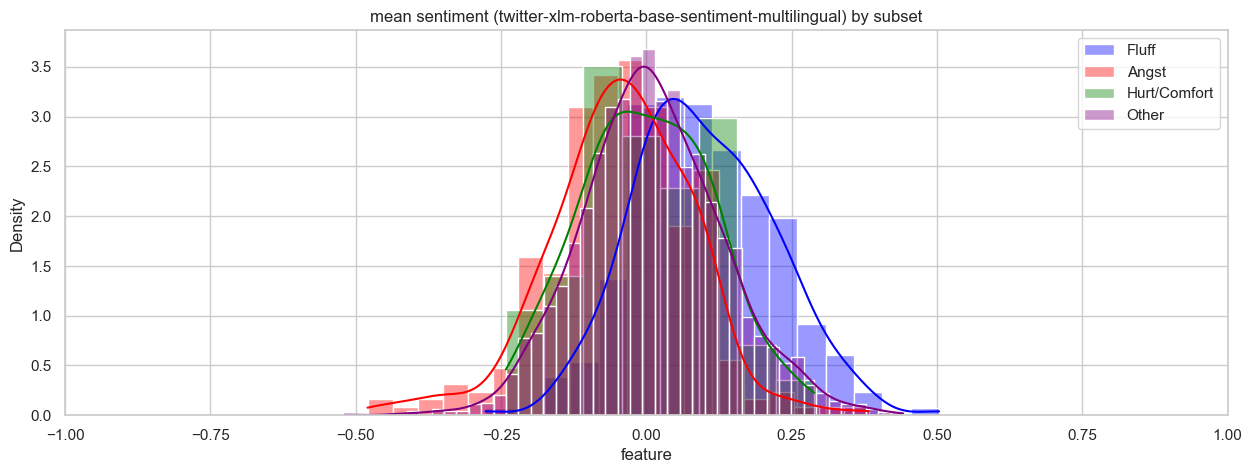

In [49]:
# Now we want to just check the distributions of the data over the tags 

sns.set_style("whitegrid")

alpha = 0.4 # transparency for the histograms
feature = 'mean_sent' # 'sd_sent'  'hurst' #feature to plot

# we want a histplot of syuzhet scores for each subset
plt.figure(figsize=(15, 5))
sns.histplot(fluff[feature], color='blue', label='Fluff', kde=True, stat="density", alpha=alpha)
sns.histplot(angst[feature], color='red', label='Angst', kde=True, stat="density", alpha=alpha)
sns.histplot(hurt_comfort[feature], color='green', label='Hurt/Comfort', kde=True, stat="density", alpha=alpha)
sns.histplot(other[feature], color='purple', label='Other', kde=True, stat="density", alpha=alpha)   
plt.title(f'mean sentiment ({METHOD_TO_USE}) by subset')
plt.xlabel(f'feature')
plt.ylabel('Density')     
if feature == 'hurst' or feature == 'sd_sent':
    # Set xlim for hurst to be between 0 and 1
    plt.xlim(0.2, 1)
else:
    # Set xlim for sd_sent to be between 0 and 1
    plt.xlim(-1, 1) # since we scaled sentiment to [-1, 1]
plt.legend()
plt.savefig(f'results/figs/{feature}_by_subset_{METHOD_TO_USE}.png', dpi=300)

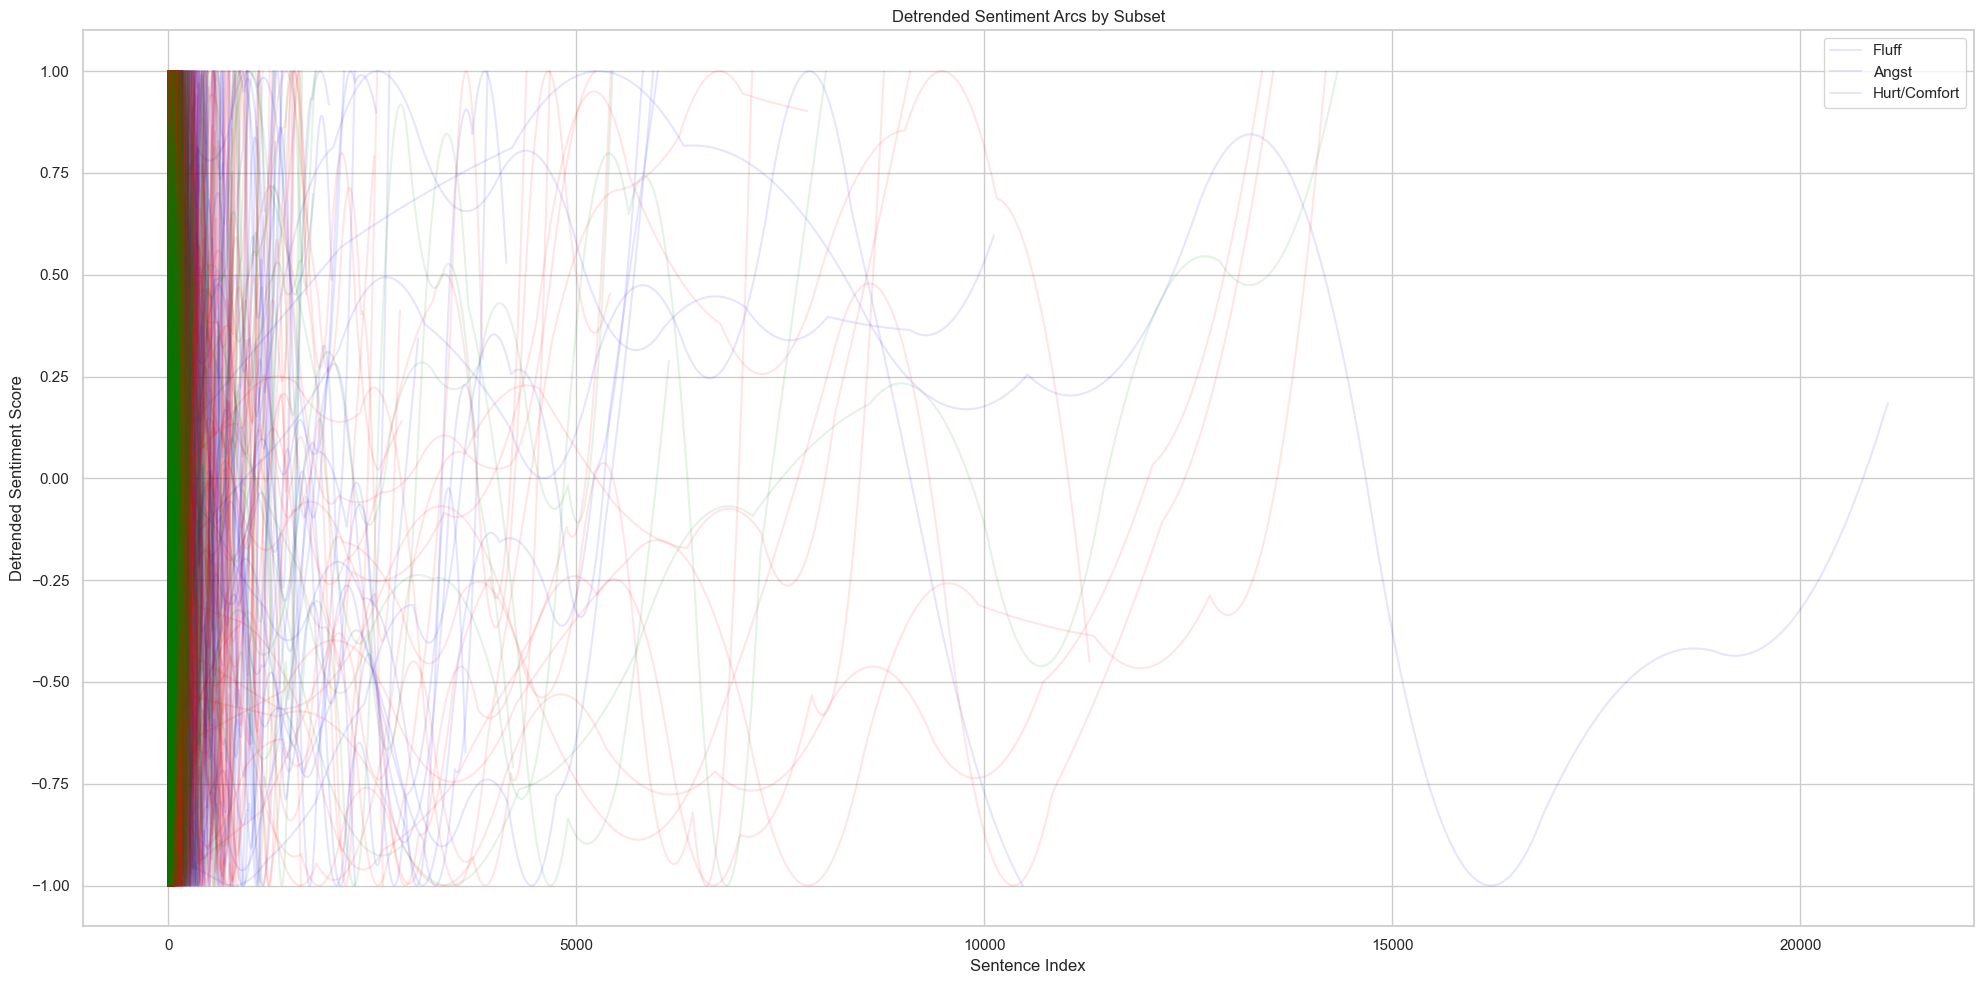

In [50]:
# now let's plot the different types of detrended arcs

fluff_arc = merged[merged['subset'] == 'fluff']
angst_arc = merged[merged['subset'] == 'angst']
hurt_comfort_arc = merged[merged['subset'] == 'hurt/comfort']
other_arc = merged[merged['subset'] == 'other']

plt.figure(figsize=(20, 10))

def plot_arcs(arcs_df, label, color):
    for arc in arcs_df['detrended_arc']:
        x = range(len(arc))  # x goes from 0 to len(arc)-1
        plt.plot(x, arc, alpha=0.1, color=color)

plot_arcs(fluff_arc, 'Fluff', 'blue')
plot_arcs(angst_arc, 'Angst', 'red')
plot_arcs(hurt_comfort_arc, 'Hurt/Comfort', 'green')
# plot_arcs(other_arc, 'Other', 'gray')

plt.title('Detrended Sentiment Arcs by Subset')
plt.xlabel('Sentence Index')
plt.ylabel('Detrended Sentiment Score')
plt.legend(['Fluff', 'Angst', 'Hurt/Comfort'])
plt.tight_layout()
plt.show()

/var/folders/z1/0qk3lyhj5r70_82k9y09_x15zptf_4/T/ipykernel_53516/2947899901.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


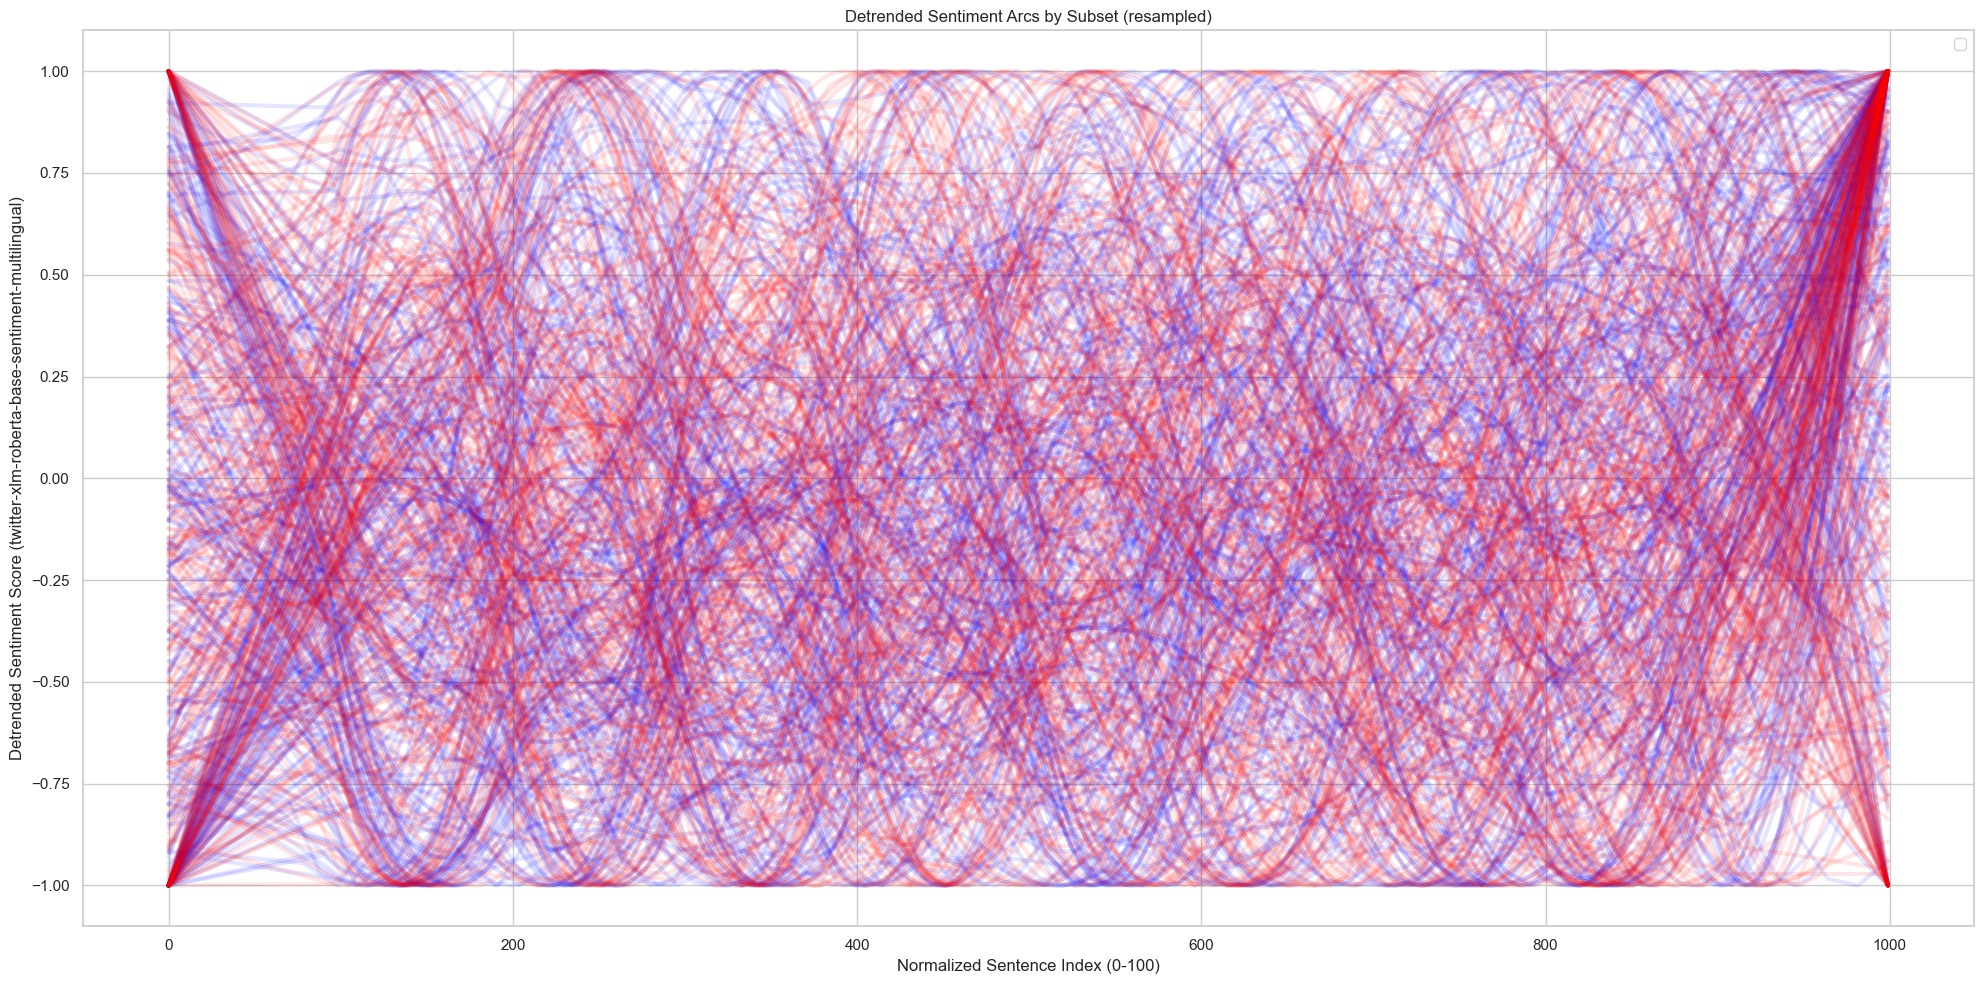

In [ ]:
data = merged.dropna(subset=['detrended_arc'])

# functions to resample arcs to a fixed length for better comparison
# this is useful for plotting, since arcs can have different lengths
def resample_arc(arc, target_length):
    arc = np.array(arc)
    original_indices = np.linspace(0, 1, num=len(arc))
    target_indices = np.linspace(0, 1, num=target_length)
    return np.interp(target_indices, original_indices, arc)

plt.figure(figsize=(20, 10))

def plot_resampled_arcs(arcs_df, label, color, target_length=1000):
    for arc in arcs_df['detrended_arc']:
        resampled = resample_arc(arc, target_length)
        plt.plot(resampled, alpha=0.1, color=color, linewidth=3)

# SAMPLING
# right we probably want to balance the groups for this plot (so each group is the same size)
min_len = min(len(fluff_arc), len(angst_arc)) # len(hurt_comfort_arc), len(other_arc))
#min_len = 2 # uncomment this to just plot 2 arcs per group (to inspect)

fluff_arc_bal = fluff_arc.sample(min_len, random_state=42)
angst_arc_bal = angst_arc.sample(min_len, random_state=42)
# hurt_comfort_arc_bal = hurt_comfort_arc.sample(min_len, random_state=42)

plot_resampled_arcs(fluff_arc_bal, 'Fluff', 'blue')
plot_resampled_arcs(angst_arc_bal, 'Angst', 'red')
#plot_resampled_arcs(hurt_comfort_arc, 'Hurt/Comfort', 'blue')

plt.title('Detrended Sentiment Arcs by Subset (resampled)')
plt.xlabel('Normalized Sentence Index (0-100)')
plt.ylabel(f'Detrended Sentiment Score ({METHOD_TO_USE})')
plt.legend()
plt.tight_layout()
plt.show()

# doesnt give us much info anyway
# looks like a bit more red in the lower right corner.......

Mean Sentiment Tests:
fluff_vs_angst: 
 t-statistic = 13.760607922353671, p-val = 0.0, 
 U-statistic = 62666.0, p-val = 0.0
fluff_vs_hurt_comfort: 
 t-statistic = 6.604644664843039, p-val = 0.0, 
 U-statistic = 16572.0, p-val = 0.0
fluff_vs_other: 
 t-statistic = 11.363746730119104, p-val = 0.0, 
 U-statistic = 554393.0, p-val = 0.0
angst_vs_hurt_comfort: 
 t-statistic = -3.0327059422648275, p-val = 0.003, 
 U-statistic = 9995.0, p-val = 0.004
angst_vs_other: 
 t-statistic = -7.077459472953755, p-val = 0.0, 
 U-statistic = 331261.0, p-val = 0.0
hurt_comfort_vs_other: 
 t-statistic = -0.6097740747674303, p-val = 0.542, 
 U-statistic = 122417.0, p-val = 0.58


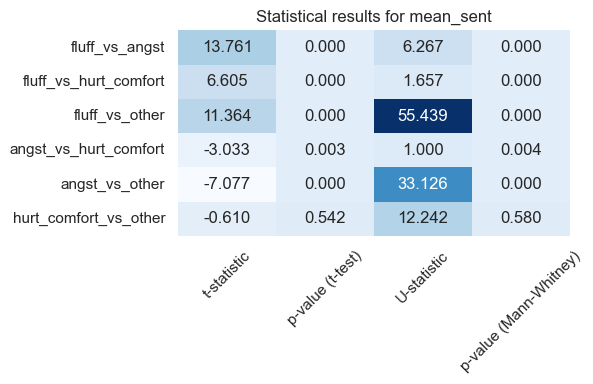

In [52]:
# get ttest, mannwhitney for hurst and mean_sent
from scipy.stats import ttest_ind, mannwhitneyu

def perform_tests(df1, df2, column):
    t_stat, p_value_t = ttest_ind(df1[column].dropna(), df2[column].dropna())
    u_stat, p_value_u = mannwhitneyu(df1[column].dropna(), df2[column].dropna())
    return t_stat, p_value_t, u_stat, p_value_u

# Perform tests for X factor
measure = 'mean_sent'#'hurst', 'sd_sent', 'sinuosity'

mean_sent_tests = {
    'fluff_vs_angst': perform_tests(fluff, angst, measure),
    'fluff_vs_hurt_comfort': perform_tests(fluff, hurt_comfort, measure),
    'fluff_vs_other': perform_tests(fluff, other, measure),
    'angst_vs_hurt_comfort': perform_tests(angst, hurt_comfort, measure),
    'angst_vs_other': perform_tests(angst, other, measure),
    'hurt_comfort_vs_other': perform_tests(hurt_comfort, other, measure)
}   

print("Mean Sentiment Tests:")
for key, value in mean_sent_tests.items():
    print(f"{key}: \n t-statistic = {value[0]}, p-val = {round(value[1],3)}, \n U-statistic = {value[2]}, p-val = {round(value[3],3)}")

# make it into a heatmap
results_df = pd.DataFrame(mean_sent_tests, index=['t-statistic', 'p-value (t-test)', 'U-statistic', 'p-value (Mann-Whitney)']).T
# scale the u statistic, /1000
results_df['U-statistic'] = results_df['U-statistic'] / 10000
# Set up the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap='Blues', cbar=False)
plt.title(f'Statistical results for {measure}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'results/figs/stats_{measure}_by_subset_{METHOD_TO_USE}.png', dpi=300)

In [46]:
# export stuff to data, if you want
if not os.path.exists('data'):
    os.makedirs('data')

# export merged df to csv
merged.to_csv('data/merged_sentiment_data.csv', index=False)